In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/LIPNLP

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/LIPNLP


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import keras
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Bidirectional, GlobalMaxPool1D, Concatenate, LSTM, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

Using TensorFlow backend.


In [0]:
#load all numpy arrays generated and saved earlier

stock_data = np.load('stock_data.npy', allow_pickle=True)
news_data = np.load('news_vector_data.npy', allow_pickle=True)
chart_data = np.load('chart_data.npy', allow_pickle=True)

news_sent = np.load('news_sentiment.npy', allow_pickle=True)
targets = np.load('targets.npy', allow_pickle=True)

In [4]:
print(news_data.shape, chart_data.shape, stock_data.shape, targets.shape, news_sent.shape)

(2502, 4089) (2502, 396, 576, 1) (2502, 3) (2502,) (2502,)


In [0]:
#train test split

train_stock_data, test_stock, train_news_data, test_news, train_chart_data, test_chart, train_news_sent, test_news_sent, train_targets, test_targets = train_test_split(stock_data, news_data, chart_data, news_sent, targets, train_size=0.9, shuffle=False)

In [0]:
MAX_SEQUENCE_LENGTH = 4089
MAX_VOCAB_SIZE = 40000
EMBEDDING_DIM = 200
num_words = 40000

#load embedding matrix generated using glove
embedding_matrix = np.load('embedding_matrix.npy', allow_pickle=True)

In [0]:
#custom embedding layer

embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [0]:
#model

in_news = Input(shape=(MAX_SEQUENCE_LENGTH,))
in_chart = Input(shape=(396, 576, 1))
in_stock = Input(shape=(3,))

news = embedding_layer(in_news)
news = Bidirectional(LSTM(10, return_sequences=True))(news)
news = GlobalMaxPool1D()(news)
news_out = Dense(1)(news)

chart = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(in_chart)
chart = MaxPooling2D(pool_size=(3, 3))(chart)
chart = Conv2D(24, kernel_size=3, strides=1, padding='same', activation='relu')(chart)
chart = MaxPooling2D(pool_size=(2, 2))(chart)
chart = Flatten()(chart)
chart = Dense(1)(chart)

stock = Dense(32)(in_stock)
stock = Dense(128)(stock)
stock = Dense(1)(stock)

concat = Concatenate(axis=1)([news_out, chart, stock])

out = Dense(32)(concat)
out = Dense(512)(out)
output = Dense(1)(out)


#setting 2 outputs, one is the actual prediction and other is for backpropagate news
model = Model([in_news, in_chart, in_stock], [output, news_out])


model.compile(loss='mae', optimizer=Adam(lr=0.01))

In [25]:
history = model.fit([train_news_data, train_chart_data, train_stock_data], [train_targets, train_news_sent], batch_size=64, epochs=40, validation_split=0.1)

Train on 2025 samples, validate on 226 samples
Epoch 1/40
2025/2025 [==============================] - 31s 15ms/step - loss: 3021.4496 - dense_24_loss: 3021.0232 - dense_17_loss: 0.4262 - val_loss: 122.7476 - val_dense_24_loss: 122.3371 - val_dense_17_loss: 0.4105
Epoch 2/40
2025/2025 [==============================] - 29s 15ms/step - loss: 17.4626 - dense_24_loss: 17.0279 - dense_17_loss: 0.4347 - val_loss: 10.5516 - val_dense_24_loss: 10.1173 - val_dense_17_loss: 0.4343
Epoch 3/40
2025/2025 [==============================] - 29s 15ms/step - loss: 3.1774 - dense_24_loss: 2.7881 - dense_17_loss: 0.3892 - val_loss: 4.4081 - val_dense_24_loss: 4.0246 - val_dense_17_loss: 0.3835
Epoch 4/40
2025/2025 [==============================] - 29s 14ms/step - loss: 2.2624 - dense_24_loss: 1.8954 - dense_17_loss: 0.3669 - val_loss: 3.3643 - val_dense_24_loss: 2.9866 - val_dense_17_loss: 0.3777
Epoch 5/40
2025/2025 [==============================] - 29s 14ms/step - loss: 2.0122 - dense_24_loss: 1.669

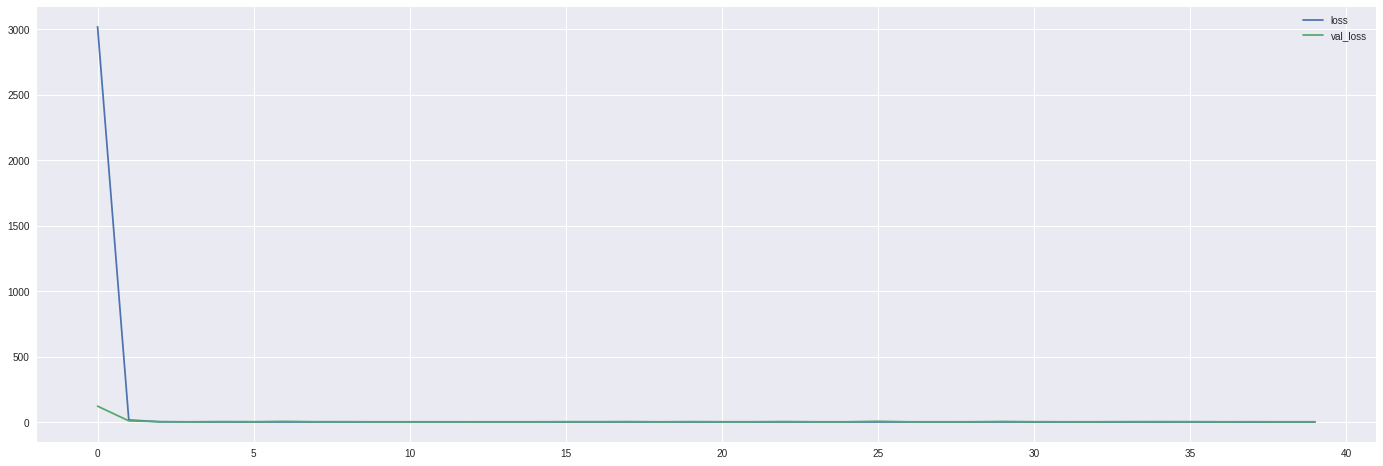

In [26]:
# plot some data
plt.figure(figsize=(24,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [0]:
# Save model
model.save('model.h5')

In [0]:
predictions, _ = model.predict([test_news, test_chart, test_stock])

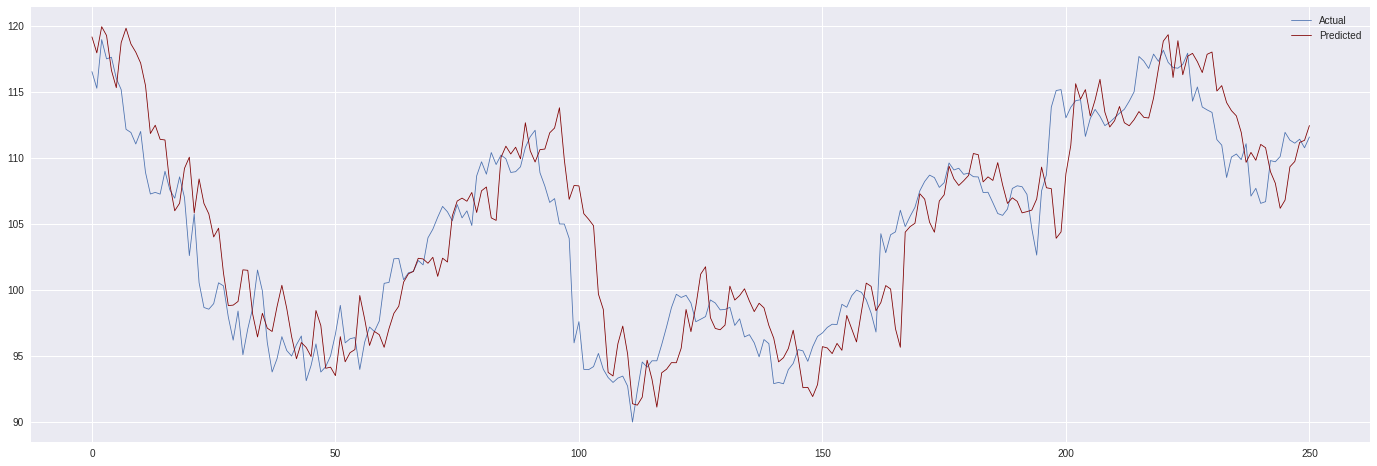

In [29]:
#plot

plt.figure(figsize=(24,8))
cycles = np.arange(len(predictions))
plt.plot(cycles, test_targets, label="Actual", lw=0.8)
plt.plot(cycles, predictions, 'maroon', label="Predicted", lw=0.8)
plt.legend()
plt.show()

In [30]:
print(metrics.mean_absolute_error(test_targets, predictions))

2.7203309323895826


In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 396, 576, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 396, 576, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4089)         0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 132, 192, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
embedding_